### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12886
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMAX|USC00058212|     4|[00 CF 00 D3 80 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TMIN|USC00058212|    13|[A0 DB 00 7E 28 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TOBS|USC00058212|     2|[40 D6 28 D8 E0 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     8|[20 D0 E0 D5 00 7...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     3|[00 46 00 D3 00 7...|2000.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USS0005K26S')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(7)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USS0005K26S'
7 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3340.6| 39.5667|   -105.8|       PRCP|USS0005K26S|    38|[40 4E 40 4E 40 4...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       PRCP|USS0005K26S|    16|[00 00 00 00 00 0...|2000.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       PRCP|USS0005K26S|    45|[00 00 40 4E 00 0...|2001.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       PRCP|USS0005K26S|    47|[00 7E 00 7E 00 0...|2005.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       PRCP|USS0005K26S|    37|[40 4E 00 00 C0 5...|2006.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       PRCP|USS0005K26S|    25|[00 00 00 00 00 0...|2007.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.

(7, 365)

In [304]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query1="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USS0005K26S')
print Query1
df2 = sqlContext.sql(Query1)
print df2.count(),'rows'
df2.show(11)
rows=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T1=np.vstack(rows)
T1=T1/10.  # scaling to make the temperature be in centingrates
shape(T1)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USS0005K26S'
11 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3340.6| 39.5667|   -105.8|       TOBS|USS0005K26S|    27|[A0 D7 E0 D8 80 D...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TOBS|USS0005K26S|    23|[E0 D5 08 D9 00 7...|2000.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TOBS|USS0005K26S|    13|[58 D8 30 D4 00 D...|2002.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TOBS|USS0005K26S|     9|[00 D8 20 D0 20 D...|2003.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TOBS|USS0005K26S|    11|[80 D1 90 D5 B0 D...|2004.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TOBS|USS0005K26S|     6|[00 D8 E0 D5 40 D...|2005.0|SSSBBBBB|
|   3340.6| 39.5667|   -105

(11, 365)

### Script for plotting yearly plots

In [279]:
#create dataframe of precipitation
df_date = pd.DataFrame(columns=('Year','Day'))
year=[1999,2000,2001,2005,2006,2007,2009]
for j in range(7):
    for k in range(365):
        i = j*365 + k
        df_date.loc[i] = (int(year[j]),int(i+1))

In [280]:
df_pre1 = T[:7,:].transpose()
df_pre2=concatenate((df_pre1[:,0],df_pre1[:,1],df_pre1[:,2],df_pre1[:,3],df_pre1[:,4],df_pre1[:,5],df_pre1[:,6]),axis=0)
df_pre3 = pd.DataFrame(df_pre2)
df_pre4 = concatenate((df_date,df_pre3),axis = 1)
df_pre = pd.DataFrame(df_pre4)
df_pre.columns = ['Year','Day','PRCP']

In [281]:
days = [31,28,31,30,31,30,31,31,30,31,30,31]
month = []
for i in range(1,13,1):
    k = [i] * days[i-1]
    month.append(k)
month = month * 7

In [282]:
import itertools
a = list(itertools.chain.from_iterable(month))
df_pre['Month'] = pd.DataFrame(a)
df_pre=df_pre[['Year','Month','Day','PRCP']]
s = (df_pre.groupby(['Month']).sum())/7
s = s.reset_index()

In [283]:
s

,Month,Year,Day,PRCP
0,1,62119.571429,34441.0,74.525112
1,2,56108.000000,31934.0,61.452567
2,3,62119.571429,36270.0,74.453683
3,4,60115.714286,36015.0,99.696324
4,5,62119.571429,38161.0,68.138951
5,6,60115.714286,37845.0,32.176897
6,7,62119.571429,40052.0,85.138951
7,8,62119.571429,41013.0,69.054688
8,9,60115.714286,40605.0,43.016741
9,10,62119.571429,42904.0,56.065290


In [268]:
df_date1 = pd.DataFrame(columns=('Year','Day'))
year=[1999,2001,2002,2003,2004,2005,2006,2007,2010,2011,2012]
for j in range(11):
    for k in range(365):
        i = j*365 + k
        df_date1.loc[i] = (int(year[j]),int(i+1))
len(df_date1)

4015

In [305]:
df_temp1 = T1[:11,:].transpose()
df_temp2=concatenate((df_temp1[:,0],df_temp1[:,1],df_temp1[:,2],df_temp1[:,3],df_temp1[:,4],df_temp1[:,5],df_temp1[:,6],df_temp1[:,7],df_temp1[:,8],df_temp1[:,9],df_temp1[:,10]),axis=0)
df_temp3 = pd.DataFrame(df_temp2)
df_temp4 = concatenate((df_date1,df_temp3),axis = 1)
df_temp = pd.DataFrame(df_temp4)
df_temp.columns = ['Year','Day','TOBS']
df_temp.head()

,Year,Day,TOBS
0,1999.0,1.0,-12.203125
1,1999.0,2.0,-15.601562
2,1999.0,3.0,-14.398438
3,1999.0,4.0,-7.800781
4,1999.0,5.0,-6.101562


In [272]:
days = [31,28,31,30,31,30,31,31,30,31,30,31]
month = []
for i in range(1,13,1):
    k = [i] * days[i-1]
    month.append(k)
month = month * 11

In [278]:
import itertools
a = list(itertools.chain.from_iterable(month))
df_temp['Month'] = pd.DataFrame(a)
df_temp=df_temp[['Year','Month','Day','TOBS']]
s1 = df_temp.groupby(['Month']).mean()
s2 = s1.reset_index()

In [284]:
s2

,Month,Year,Day,TOBS
0,1,2005.454545,1841.0,-7.542722
1,2,2005.454545,1870.5,-8.529931
2,3,2005.454545,1900.0,-5.432080
3,4,2005.454545,1930.5,-2.794226
4,5,2005.454545,1961.0,0.564623
5,6,2005.454545,1991.5,4.502890
6,7,2005.454545,2022.0,7.302453
7,8,2005.454545,2053.0,6.405590
8,9,2005.454545,2083.5,3.492971
9,10,2005.454545,2114.0,-0.171462


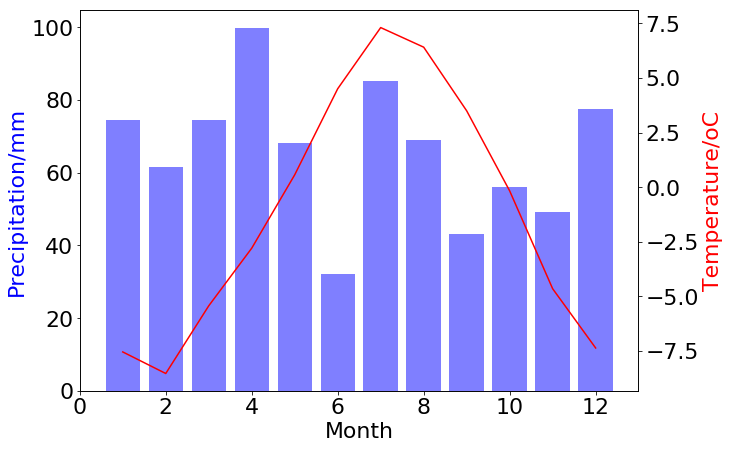

In [301]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
ax1 = ax.twinx()
ax.bar(s['Month'],s['PRCP'], align='center', alpha=0.5, color ='blue')
ax1.plot(s2['Month'],s2["TOBS"], 'r-')
ax.set_xlabel('Month')
ax.set_ylabel('Precipitation/mm', color = 'blue')
ax1.set_ylabel('Temperature/oC', color = 'r')
#ax.set_title("Multiple Year's Mean")
#plt.rcParams.update({'font.size': 22})
#plt.plot(s['PRCP'])
#ax.legend(loc = 1)
#title('A sample of graphs');

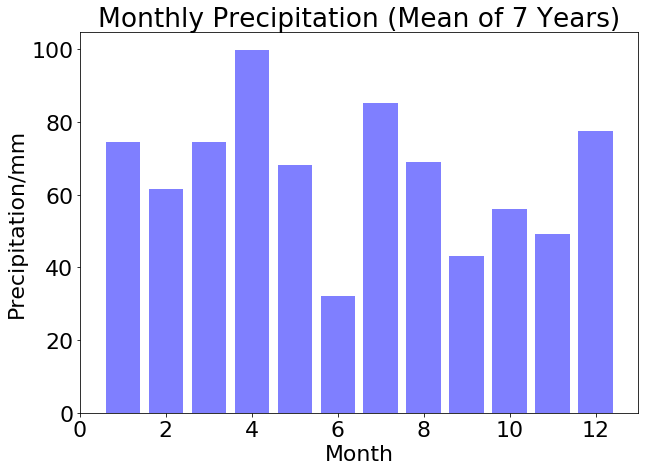

In [307]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
ax.bar(s['Month'],s['PRCP'], align='center', alpha=0.5, color ='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Precipitation/mm')
ax.set_title("Monthly Precipitation (Mean of 7 Years)")
#plt.rcParams.update({'font.size': 22})
#plt.plot(s['PRCP'])
#ax.legend(loc = 1)
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [240]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

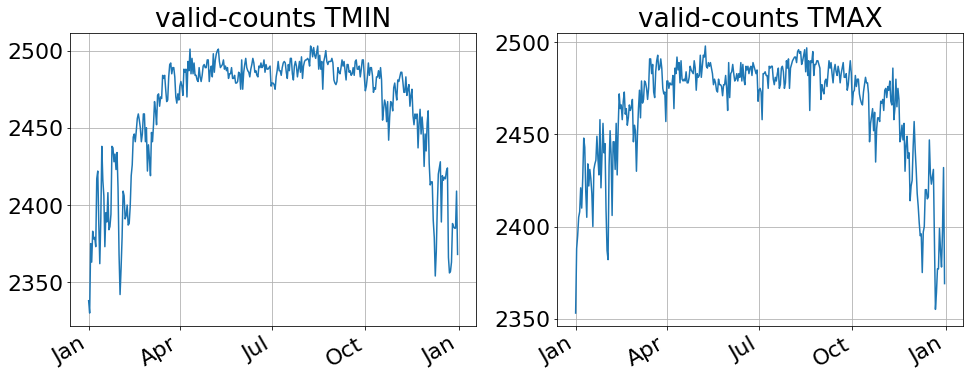

In [241]:
plot_pair(['TMIN','TMAX'],plot_valid)

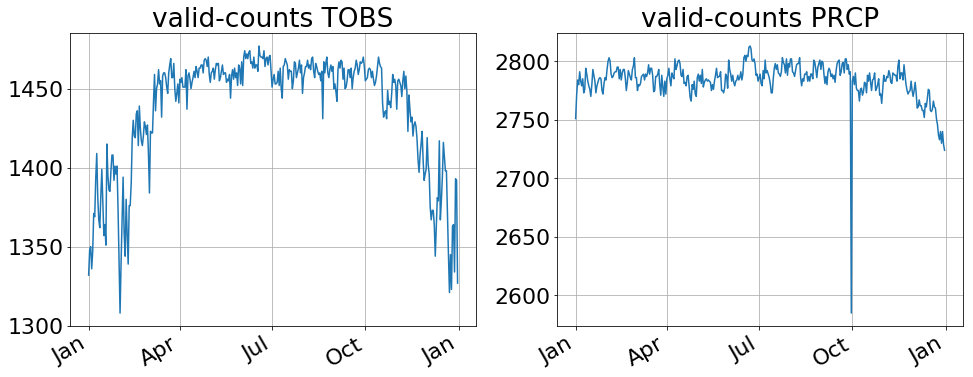

In [242]:
plot_pair(['TOBS','PRCP'],plot_valid)

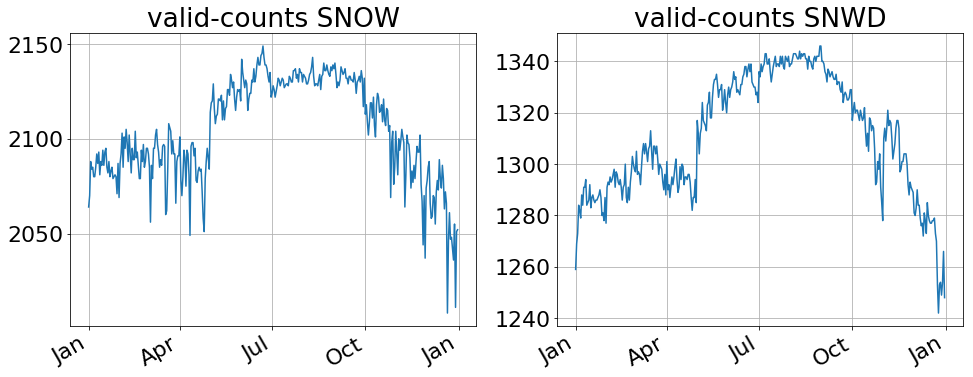

In [243]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [244]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

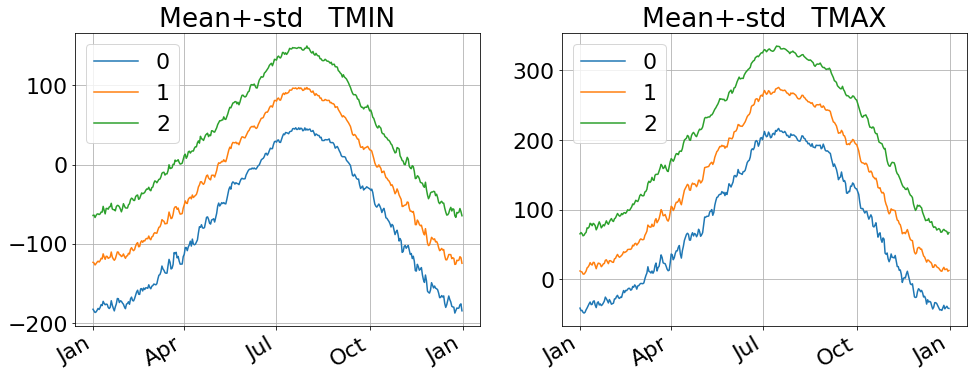

In [245]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

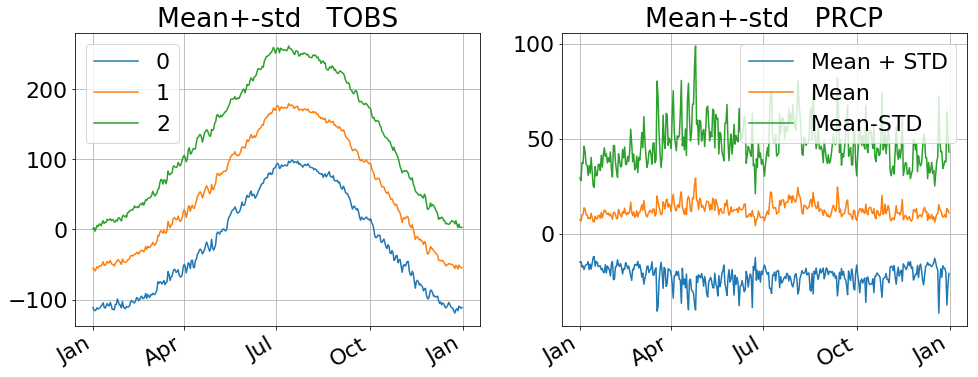

In [246]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
plt.legend(["Mean + STD", "Mean","Mean-STD"])

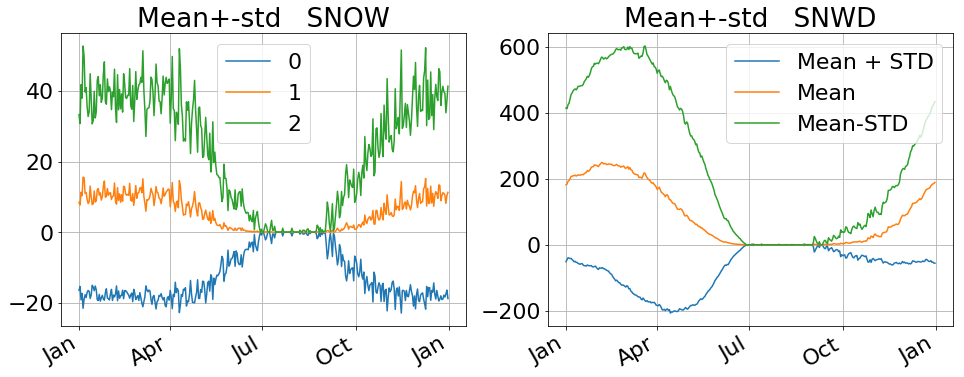

In [247]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
plt.legend(["Mean + STD", "Mean","Mean-STD"])

### plotting top 3 eigenvectors

In [16]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

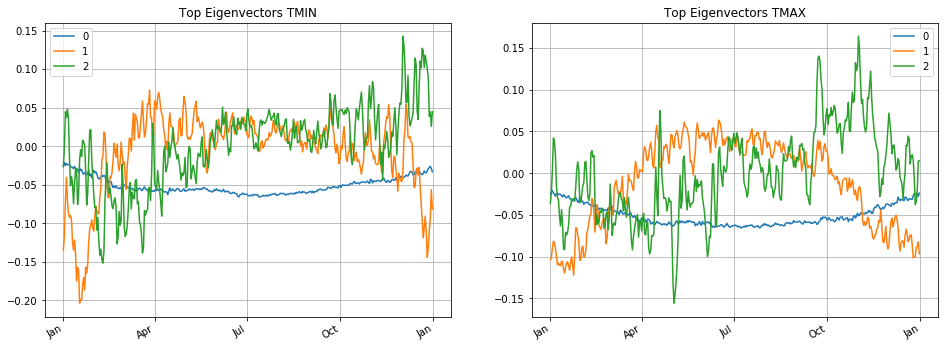

In [17]:
plot_pair(['TMIN','TMAX'],plot_eigen)

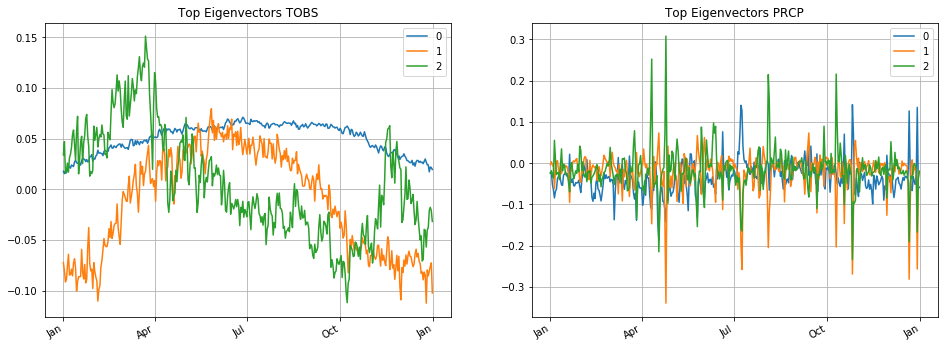

In [18]:
plot_pair(['TOBS','PRCP'],plot_eigen)

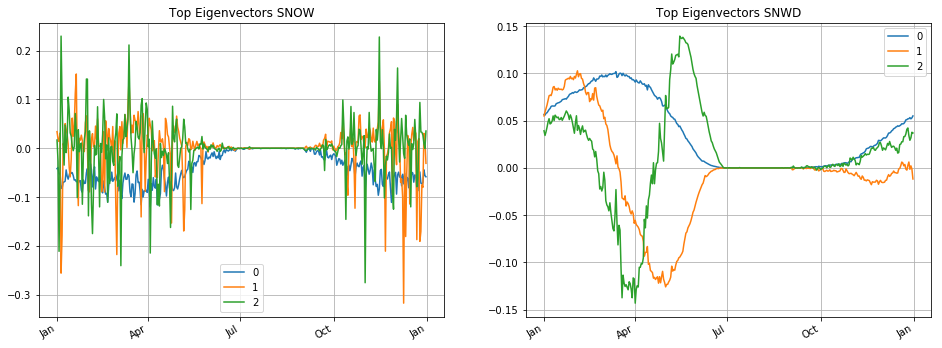

In [19]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [20]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

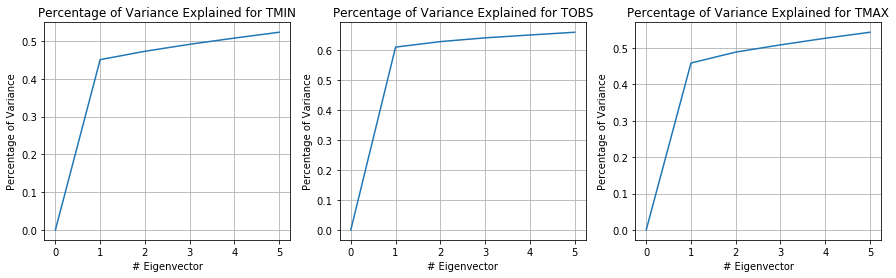

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

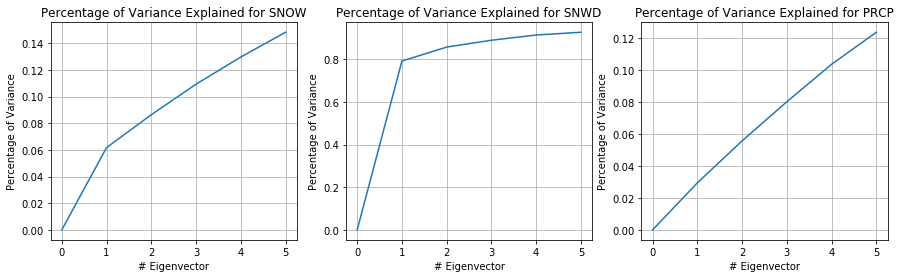

In [22]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()